In [1]:
%matplotlib inline

In [25]:
from nb_import import *

In [2]:
import matplotlib.pyplot as plt

In [8]:
import tools

# Force layout

The expression for the stress to optimise is: $stress(X) = \sum_{i<j}w_{ij}(||X_i - X_j|| - d_{ij})^2$ with $w_{ij} = d_{ij}^{-2}$, $||X_i - X_j||$ the euclidean norm computed in the low-dimensional embedding and $d_{ij}$ representing the pairwise distance in the high-dimensional embedding.

The gradient for this cost has an analytical solution equal to:

$grad_i(stress(X_i)) = \sum_j 4 w_{ij} \frac{(X_i - X_j)}{||X_i - X_j||} (||X_i - X_j|| - d_{ij})$

This expression can be computed in different ways. An explicit way does implement the computation for the gradient of the stress:

```python
def force(self):
    # hd_ij, ld_ij: pairwise distances in high, low dimensional space resp.

    pdist = ss.distance.pdist(self, 'euclidean')
    ld_ij_2 = ss.distance.squareform(pdist)

    F_ij_2 = (ld_ij_2 - self.hd_ij) / (ld_ij_2 + EPSILON)
    F_ij = F_ij_2[:,:] * self.inv_hd_ij_2

    a = self[:, None, :]
    ld_ij_1 = (a - a.swapaxes(0,1))

    F_ij = F_ij[:,:,None] * ld_ij_1

    F_i = np.sum(F_ij, axis=1)

    return 4*F_i
```

It is also possible to use autograd to compute the gradient of a given cost:


```python
def stress(X):
    X = X[:, None, :]
    ld_ij_2 = np.sqrt(np.sum(((X - X.swapaxes(0,1))**2), axis=2) + EPSILON)
    res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
    return res

gradient = grad(stress)
```

Similar to a N-body simulation, an optimisation can take place in which the gradient descent is used.

```python
def gd(grad, x, callback=None, num_iters=200):
    for i in range(num_iters):
        g = grad()
        x -= g/2  # if full gradient, optimisation is unstable
    return x

def sgd(grad, x, callback=None, num_iters=200, step_size=0.1, mass=0.9):
    velocity = np.zeros(x.shape)
    for i in range(num_iters):
        g = grad()
        if callback: callback(x, i, g)
        velocity = mass * velocity - (1.0 - mass) * g
        x += step_size * velocity
    return x
```

In [7]:
from pyforce import pyforce

In [47]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

# MNIST-2k

In [9]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-2k')

In [10]:
pdist = pyforce.Distances(X_train)

In [28]:
pca = PCA(n_components=2).fit_transform(X_train)
pca = preprocessing.scale(pca)

In [29]:
fe_pca = pyforce.ForceEmbedding(pca.copy(), pdist)

In [30]:
%time fe_pca.optimize(n_iter=100)

CPU times: user 1min 19s, sys: 9.28 s, total: 1min 28s
Wall time: 22.3 s


ForceEmbedding([[ -1.90509526,  28.43665478],
                [ 18.74753823, -27.99213378],
                [ 24.33695193, -19.01942616],
                ...,
                [ 18.18578632,  -6.86080494],
                [ -2.17432384,  22.03563984],
                [ -1.51093235,  13.56105227]])

In [37]:
fe_pca_sgd = pyforce.ForceEmbedding(pca.copy(), pdist)

In [38]:
%time fe_pca_sgd.optimize(n_iter=100, method='sgd')

CPU times: user 1min 22s, sys: 9.25 s, total: 1min 31s
Wall time: 22.9 s


ForceEmbedding([[ -2.13806168,  29.60849671],
                [ 15.96401131, -31.4376716 ],
                [ 25.55512634, -19.8898831 ],
                ...,
                [ 19.31722508,  -4.98926219],
                [ -3.5292975 ,  21.76765851],
                [  2.61676462,  14.01113037]])

## plots

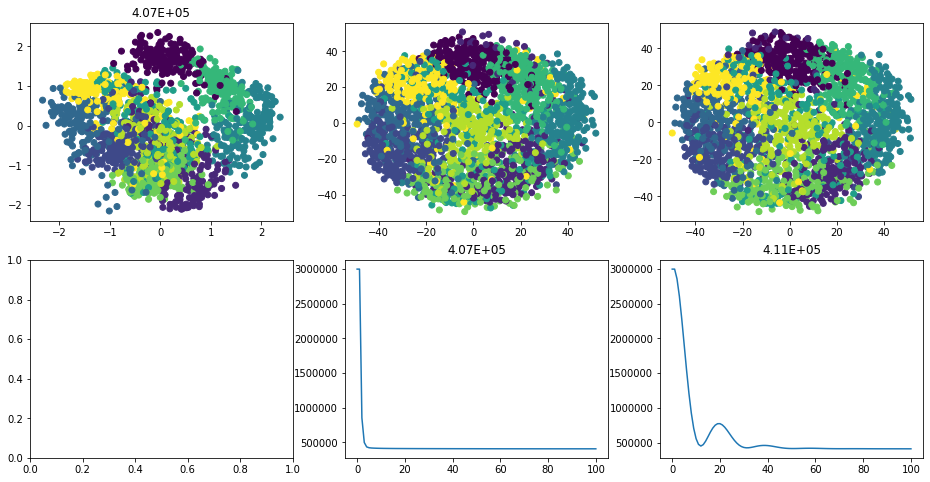

In [39]:
fig, ax = plt.subplots(2,3, figsize=(16,8))

ax[0,0].scatter(pca[:,0], pca[:,1], c=y_train)
_=ax[0,0].set_title("{:.2E}".format(fe_pca.stress()))

ax[0,1].scatter(fe_pca[:,0], fe_pca[:,1], c=y_train)
ax[1,1].plot(np.array(fe_pca.error))
_=ax[1,1].set_title("{:.2E}".format(fe_pca.stress()))

ax[0,2].scatter(fe_pca_sgd[:,0], fe_pca_sgd[:,1], c=y_train)
ax[1,2].plot(np.array(fe_pca_sgd.error))
_=ax[1,2].set_title("{:.2E}".format(fe_pca_sgd.stress()))

In [40]:
fe_pca_1k = pyforce.ForceEmbedding(pca.copy(), pdist)

In [41]:
%time fe_pca_1k.optimize(n_iter=1000)

CPU times: user 13min 12s, sys: 1min 28s, total: 14min 40s
Wall time: 3min 40s


ForceEmbedding([[ -1.38643358,  28.42393893],
                [ 19.01256576, -27.06881349],
                [ 25.2832434 , -17.59459255],
                ...,
                [ 17.92249205,  -7.79757608],
                [ -2.53582784,  22.82835082],
                [ -1.84321066,  12.16880386]])

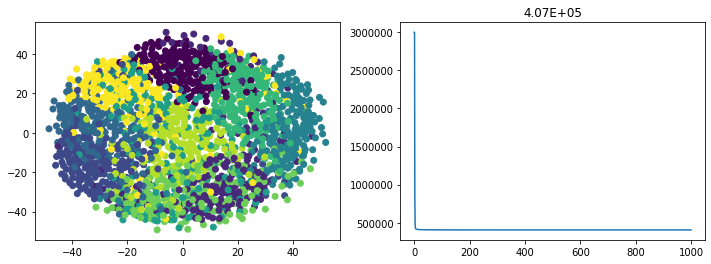

In [44]:
 fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(fe_pca_1k[:,0], fe_pca_1k[:,1], c=y_train)
ax[1].plot(np.array(fe_pca_1k.error))
_=ax[1].set_title("{:.2E}".format(fe_pca_1k.stress()))


# MNIST-70K root N

In [45]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-70k')

## sample root N

In [46]:
N = X_train.shape[0]
rootN = np.int(np.sqrt(N))
rootN_ids = np.random.choice(N, size=rootN, replace=False)
rootN_data = X_train[rootN_ids]

In [48]:
pca = PCA(n_components=2).fit_transform(rootN_data)
pca = preprocessing.scale(pca)

In [49]:
pdist = pyforce.Distances(rootN_data)

In [50]:
fe_rootN = pyforce.ForceEmbedding(pca.copy(), pdist)

In [54]:
%time _=fe_rootN.optimize(n_iter=100, method='sgd')

CPU times: user 1.63 s, sys: 59.7 ms, total: 1.69 s
Wall time: 427 ms


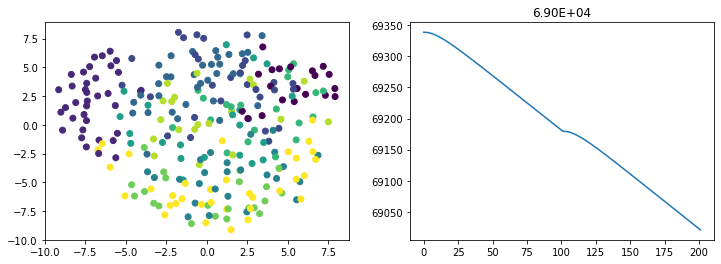

In [55]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(fe_rootN[:,0], fe_rootN[:,1], c=y_train[rootN_ids])
ax[1].plot(np.array(fe_rootN.error))
_=ax[1].set_title("{:.2E}".format(fe_rootN.stress()))
